In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import copy

# 1. DATA

First of all we decompressed the '.gz' files and then added a row as a header ('from to time').

In [2]:
#load data
answers_to_questions = pd.read_table('answers_to_questions', sep=' ')
comments_to_answers = pd.read_table('comments_to_answers', sep=' ')
comments_to_questions = pd.read_table('comments_to_questions', sep=' ')

In [3]:
answers_to_questions.head()

,from,to,time
0,9,8,1217567877
1,1,1,1217573801
2,13,1,1217606247
3,17,1,1217617639
4,48,2,1217618182


If you wanna work on a smaller range of time use the code below. For example let's just take the data from 2010.

In [4]:
#create timestamps for the first and last days of 2010
import time
start = '01/01/2010'
end = '31/12/2010'
start = int(time.mktime(datetime.datetime.strptime(start, "%d/%m/%Y").timetuple()))
end = int(time.mktime(datetime.datetime.strptime(end, "%d/%m/%Y").timetuple()))


#take only data from the first half of 2009
answers_to_questions = answers_to_questions[(answers_to_questions.time >= start) & (answers_to_questions.time <= end)]
comments_to_answers = comments_to_answers[(comments_to_answers.time >= start) & (comments_to_answers.time <= end)]
comments_to_questions = comments_to_questions[(comments_to_questions.time >= start) & (comments_to_questions.time <= end)]
#reset the index
answers_to_questions.reset_index(drop = True, inplace = True)
comments_to_answers.reset_index(drop = True, inplace = True)
comments_to_questions.reset_index(drop = True, inplace = True)

Let's deal with dates!

In [5]:
#convert timestamps
answers_to_questions['time'] = answers_to_questions['time'].apply(datetime.datetime.fromtimestamp).astype(str)
comments_to_answers['time'] = comments_to_answers['time'].apply(datetime.datetime.fromtimestamp).astype(str)
comments_to_questions['time'] = comments_to_questions['time'].apply(datetime.datetime.fromtimestamp).astype(str)

#let's just take year, month, day (in this order)
answers_to_questions['time'] = answers_to_questions['time'].str[:10]
comments_to_answers['time'] = comments_to_answers['time'].str[:10]
comments_to_questions['time'] = comments_to_questions['time'].str[:10]

In [6]:
answers_to_questions.head()

,from,to,time
0,235648,46724,2010-01-01
1,232279,117859,2010-01-01
2,235648,147095,2010-01-01
3,79668,73630,2010-01-01
4,202019,46724,2010-01-01


In [7]:
comments_to_answers.head()

,from,to,time
0,87834,85597,2010-01-01
1,164506,45914,2010-01-01
2,222908,187606,2010-01-01
3,71134,71134,2010-01-01
4,241577,133910,2010-01-01


In [8]:
comments_to_questions.head()

,from,to,time
0,1831,229728,2010-01-01
1,144424,147095,2010-01-01
2,121363,198729,2010-01-01
3,30587,86288,2010-01-01
4,231677,31699,2010-01-01


Each dictionary represents a adjacency list. 

The dictionary *Graph* represent the merge of the 3 single graphs: for each node *u* there are all the nodes *v* , represented as dictionaries, which answered to a question of node *u*, commented an answer of node *u* or commented a question of node *u*. This graph is directed and self-connections are allowed. Each dictionary represented by the nodes *v* cointains a list of all the dates of the actions.

We can think at the dictionary *Graph* as am adjacency list. Moreover each link is weigthed, and the weight is equal to the number of actions taken, which can be calculated by taking the length of the list inside each dictionary *v*.

In [9]:
#graph for answers_to_questions
answers_to_questions_graph = {}

#first create a dictioary where the key is the starting node and contains a tuple with the arriving node and the time
for i in range(len(answers_to_questions)):
    if answers_to_questions['from'][i] not in answers_to_questions_graph:
        answers_to_questions_graph[answers_to_questions['from'][i]] = []
    answers_to_questions_graph[answers_to_questions['from'][i]].append((answers_to_questions.to[i], answers_to_questions.time[i]))
    

#let's now make a dictionary of dictionaries where the first key is the starting node,
#the second the arriving node (which cointains a list of times) 
for key in answers_to_questions_graph.keys():
    supp = {}
    for i in range(len(answers_to_questions_graph[key])):
        if answers_to_questions_graph[key][i][0] not in supp:
            supp[answers_to_questions_graph[key][i][0]] = []
        supp[answers_to_questions_graph[key][i][0]].append(answers_to_questions_graph[key][i][1])
    answers_to_questions_graph[key] = supp
    
#the procedure for the following cells is the same.

In [10]:
#graph for comments_to_answers
comments_to_answers_graph = {}

for i in range(len(comments_to_answers)):
    if comments_to_answers['from'][i] not in comments_to_answers_graph:
        comments_to_answers_graph[comments_to_answers['from'][i]] = []
    comments_to_answers_graph[comments_to_answers['from'][i]].append((comments_to_answers.to[i], comments_to_answers.time[i]))
    


for key in comments_to_answers_graph.keys():
    supp = {}
    for i in range(len(comments_to_answers_graph[key])):
        if comments_to_answers_graph[key][i][0] not in supp:
            supp[comments_to_answers_graph[key][i][0]] = []
        supp[comments_to_answers_graph[key][i][0]].append(comments_to_answers_graph[key][i][1])
    comments_to_answers_graph[key] = supp

In [11]:
#graph for comments_to_questions
comments_to_questions_graph = {}

for i in range(len(comments_to_questions)):
    if comments_to_questions['from'][i] not in comments_to_questions_graph:
        comments_to_questions_graph[comments_to_questions['from'][i]] = []
    comments_to_questions_graph[comments_to_questions['from'][i]].append((comments_to_questions.to[i], comments_to_questions.time[i]))
    

for key in comments_to_questions_graph.keys():
    supp = {}
    for i in range(len(comments_to_questions_graph[key])):
        if comments_to_questions_graph[key][i][0] not in supp:
            supp[comments_to_questions_graph[key][i][0]] = []
        supp[comments_to_questions_graph[key][i][0]].append(comments_to_questions_graph[key][i][1])
    comments_to_questions_graph[key] = supp

In [12]:
#total graph
graph = {}

#same procedure, but takes data from all three dataframes

for i in range(len(answers_to_questions)):
    if answers_to_questions['from'][i] not in graph:
        graph[answers_to_questions['from'][i]] = []
    graph[answers_to_questions['from'][i]].append((answers_to_questions.to[i], answers_to_questions.time[i]))
    
for i in range(len(comments_to_answers)):
    if comments_to_answers['from'][i] not in graph:
        graph[comments_to_answers['from'][i]] = []
    graph[comments_to_answers['from'][i]].append((comments_to_answers.to[i], comments_to_answers.time[i]))
    
for i in range(len(comments_to_questions)):
    if comments_to_questions['from'][i] not in graph:
        graph[comments_to_questions['from'][i]] = []
    graph[comments_to_questions['from'][i]].append((comments_to_questions.to[i], comments_to_questions.time[i]))
    
    
    
for key in graph.keys():
    supp = {}
    for i in range(len(graph[key])):
        if graph[key][i][0] not in supp:
            supp[graph[key][i][0]] = []
        supp[graph[key][i][0]].append(graph[key][i][1])
    graph[key] = supp

# 2. Implementation of the backend

### Functionality 1 - Get the overall features of the graph

In [13]:
from collections import Counter

In [14]:
def directed(a_graph):                          #most likely it will always be directed... (cause of construction)
    for key in a_graph.keys():
        for key_ in a_graph[key].keys():
            if key_ not in a_graph.keys():
                return('directed')
            if key not in a_graph[key_].keys():
                return('directed')
            if Counter(a_graph[key][key_]) != Counter(a_graph[key_][key]):
                return('directed')
    return('undirected')                       #it basically checks 'simmetry'

In [15]:
def n_users(a_graph):                          #counts all the nodes that appear in the graph
    users=[]
    for key in a_graph.keys():
        users.append(list(a_graph[key].keys()))
    users.append(list(a_graph.keys()))
    users = set(list(itertools.chain.from_iterable(users)))
    return(len(users))

In [16]:
def n_answers_comments(a_graph):     #equal number of links*weight(len of the list)
    n = 0
    for key in a_graph.keys():
        for key_ in a_graph[key].keys():
            n = n + len(a_graph[key][key_])
    if directed(a_graph) == 'directed':
        return(n)
    else:
        return(n/2)                  #it basically counts the number of items in the lists

In [17]:
def avg_n_links(a_graph):
    if directed(a_graph) == 'directed':
        return(n_answers_comments(a_graph)/n_users(a_graph))
    else:
        return(2*n_answers_comments(a_graph)/n_users(a_graph))

In [18]:
def density(a_graph):
    n = n_users(a_graph)
    if directed(a_graph) == 'directed':
        return(n_answers_comments(a_graph)/(n*(n-1)))
    else:
        return(2*n_answers_comments(a_graph)/(n*(n-1)))

In [19]:
def sparse(a_graph):
    if density(a_graph) < 0.5:        #use a treshold
        return('sparse')
    else:
        return('dense')

In [20]:
def Functionality_1(a_graph):         #combine the previous functions and makes a dictionary
   
    return({'directed': directed(a_graph), 'n_users': n_users(a_graph), 'n_answers_comments': n_answers_comments(a_graph),
           'avg_n_links': avg_n_links(a_graph), 'density': density(a_graph), 'sparse': sparse(a_graph)})

In [21]:
Functionality_1(answers_to_questions_graph)

{'directed': 'directed',
 'n_users': 220685,
 'n_answers_comments': 1444706,
 'avg_n_links': 6.5464621519360175,
 'density': 2.966441677663998e-05,
 'sparse': 'sparse'}

### Functionality 2 - Find the best users!

I guess directed and unweighted versions are better in this case, cause I don't think the number of interactions is really important here.

In [22]:
from collections import deque 

def s_path(graph, a_node, users):                       #find len of shortest path from a_node to every other node 
    distances = {}
    visited = {}                                        #unweighted version cause it makes more sense to me
    for user in users:
        distances[user] = 999999999
    distances[a_node] = 0
    q = deque()
    q.append(a_node)
    visited[a_node] = True
    
    while q:                                            #uses a queue
        current = q[0]                                  #takes first in queue
        q.popleft()
        
        if current in graph.keys():                     #visits every son of the current node
            for x in list(graph[current]):
                if x not in visited.keys():
                    q.append(x)
                    visited[x] = True
                    
                if x in distances.keys():                        #checks and updates
                    if distances[x] > distances[current] + 1:
                        distances[x] = distances[current] + 1 
        
                    
    for key in list(distances):                                  #removes not connected nodes
        if distances[key] == 999999999:
            distances.pop(key)
                
    return distances

In [23]:
def s_path_1(graph, a_node, users):                     #same as the previous function but it also saves the path
    distances = {}
    visited = {}
    path = {}
    for user in users:
        distances[user] = 999999999
    distances[a_node] = 0
    q = deque()
    q.append(a_node)
    visited[a_node] = True
    path[a_node] = []
    
    while q:                                           
        current = q[0]                                  
        q.popleft()
        
        if current in graph.keys():                    
            for x in list(graph[current]):
                if x not in visited.keys():
                    q.append(x)
                    visited[x] = True
                    
                if x in distances.keys():                        
                    if distances[x] > distances[current] + 1:
                        distances[x] = distances[current] + 1
                        path[x] = path[current].copy()                     #saves path
                        path[x].append(current)

                
    return path

In [24]:
def betweeness(a_graph, a_node):
    users=[]                                                              #find users
    for key in a_graph.keys():
        users.append(list(a_graph[key].keys()))
    users.append(list(a_graph.keys()))
    users = set(list(itertools.chain.from_iterable(users)))
    
    paths = []
    for user in users:                                                   #find all the shortest paths
        a = s_path_1(a_graph, user, users)
        for key in a.keys():
            if a_node in a[key]:                                         #1 if our node is in path, 0 otherwise
                paths.append(1)
            else:
                paths.append(0)
        
    return(sum(paths)/len(paths))                                        #shortest paths passing from our node/all shortest paths

In [63]:
def pagerank(a_graph, a_node):                                           #0.85 is the google damping factor
    
    users = []                                                            #find users
    for key in a_graph.keys():
        users.append(list(a_graph[key].keys()))
    users.append(list(a_graph.keys()))
    users = set(list(itertools.chain.from_iterable(users)))
    users.remove(a_node)
    
    fac = 0
    
    for user in users:                                                   #finds parents and calcute pagerank
        if user in a_graph.keys():
            if a_node in a_graph[user].keys():
                fac_1 = pagerank(a_graph, user)/len(a_graph[user])       #recursive
                fac = fac_1 + fac
    
    return((1-0.85)/len(users)+0.85*fac)
    

In [26]:
def closeness(a_graph, a_node):
    users=[]                                                             #find users
    for key in a_graph.keys():
        users.append(list(a_graph[key].keys()))
    users.append(list(a_graph.keys()))
    users = set(list(itertools.chain.from_iterable(users)))
    users.remove(a_node)
    
    distances = s_path(a_graph, a_node, users)
    
    sum_d = 0
    for key in distances.keys():
        sum_d = sum_d + distances[key]

    return(len(users)/sum_d)                                              #n-1/sum of all shortest path from a_node to each user

In [27]:
def degreec(a_graph, a_node):    #it uses in-degree without taking count of the weigth (it makes more sense to me)
    users=[]                      
    for key in a_graph.keys():
        users.append(list(a_graph[key].keys()))
    users.append(list(a_graph.keys()))
    users = set(list(itertools.chain.from_iterable(users)))           #find all users
    users.remove(a_node)
    
    degreec= 0
    
    for user in users:
        if user in a_graph.keys():                                    #find in-degree
            if a_node in a_graph[user].keys():
                degreec = degreec + 1
                
    return(degreec/len(users))

In [28]:
def reduceGraph(graph, start_date, end_date):    #check all the dates and drop if not in range of time
    a_graph = copy.deepcopy(graph)
    start = int(time.mktime(datetime.datetime.strptime(start_date, "%Y-%m-%d").timetuple()))
    end = int(time.mktime(datetime.datetime.strptime(end_date,"%Y-%m-%d").timetuple()))
    for key in list(a_graph):
        for key_ in list(a_graph[key]):
            for i in range(len(a_graph[key][key_])):
                if int(time.mktime(datetime.datetime.strptime(a_graph[key][key_][i], "%Y-%m-%d").timetuple())) > end:
                    a_graph[key][key_][i] = 0
                elif int(time.mktime(datetime.datetime.strptime(a_graph[key][key_][i], "%Y-%m-%d").timetuple())) < start:
                    a_graph[key][key_][i] = 0
            a_graph[key][key_] = list(filter(lambda num: num != 0, a_graph[key][key_]))
    
            if len(a_graph[key][key_]) == 0:   #drop keys if empty
                a_graph[key].pop(key_)
        if len(a_graph[key]) == 0:
            a_graph.pop(key)
            
    return(a_graph)

In [29]:
def Functionality_2 (a_node, start_date, end_date, metric, a_graph = graph):
    a_graph_1 = reduceGraph(a_graph, start_date, end_date)
    if metric == 'Betweeness':
        return(betweeness(a_graph_1, a_node))
    if metric == 'PageRank':
        return(pagerank(a_graph_1, a_node))
    if metric == 'ClosenessCentrality':
        return(closeness(a_graph_1, a_node))
    if metric == 'DegreeCentrality':
        return(degreec(a_graph_1, a_node))

In [30]:
Functionality_2(227411, "2010-01-01", "2010-01-01", 'Betweeness')

0.01779978103682672

In [66]:
Functionality_2(227411, "2010-01-01", "2010-01-01", 'PageRank')   #doesn't work :( seems like there's a cycle

RecursionError: maximum recursion depth exceeded in comparison

In [32]:
Functionality_2(227411, "2010-01-01", "2010-01-01", 'ClosenessCentrality')

0.31456466497258256

In [33]:
Functionality_2(227411, "2010-01-01", "2010-01-01", 'DegreeCentrality')

0.0012755102040816326

### Functionality 3 - Shortest Ordered Route

### Functionality 4 - Disconnecting graphs

# 3. Implementation of the frontend

### Visualization 1 - Visualize the overall features of the graph

In [34]:
def Visualization_1(a_graph):
    info = pd.DataFrame.from_dict(Functionality_1(a_graph), orient='index', columns = ["Graph property"])
    display(info)
    degree = [] #degrees af all nodes
    for key in a_graph.keys(): #iterating through nodes to obtain degrees
        n = 0
        for key_ in a_graph[key].keys():
            n = n + len(a_graph[key][key_])
        if directed(a_graph) == 'indirected':
            n = n/2
        degree.append(n)
    #plt.hist(degree, bins = 200)
    fig, axs = plt.subplots(1, 2,figsize=(20,5))
    fig.suptitle('Distribution of nodes degrees')
    axs[0].hist(degree, bins = 200)
    axs[0].set_title('All degree values')
    axs[1].hist(degree, bins = 200, range = (0,60))
    axs[1].set_title('Most frequant degree values')

,Graph property
directed,directed
n_users,220685
n_answers_comments,1444706
avg_n_links,6.546462
density,0.00003
sparse,sparse


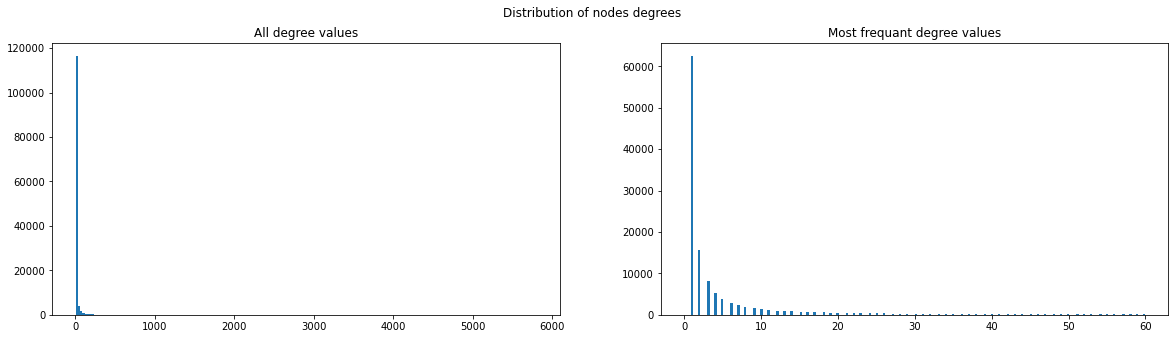

In [35]:
Visualization_1(answers_to_questions_graph)

# 4. Algorithmic question

A number n of kids are in a camp. Between some k pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

Give an algorithm that is linear in n and k that is able to answer whether such an assignment is possible and, if so, return one.



As an input we have $k$ pairs of child that fight and n name all of children. Let's treat $n$ names of children as $n$ nodes  of graph and $k$ pairs as pairs of nodes which connected by edges. This will be our graph G. Then the question "if it is possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory" is equal to the question "is it possible to assign to each noed of graph G value of 1 or 0, so that every two connected nodes have diffrent values". To check it, we can run DFS from each node, but each time when we will go to the nodes connected to the previous node ($v$) we will assign them another value than have $v$. If the node already has assigned colur and it's equal to value of $v$, than the answer is impossible. If we are able to finish DFS from each node without such situation, than its possible, as we have assign 0 and 1 values to all nodes, and every node connected to nodes with different values. Let's implement the algorithm.

In [36]:
#typical DFS function, except we assing the opposite values to connected nodes
def DFS_value(i, adj, visit, val, t):
    visit[i] = 1 #now this node is visited
    for j in adj[i]: #for all connected with i nodes
        if val[j] == None:    #if value for connector node is not defined,
            val[j] = 1 - val[i]   #we assigned the opposite to connected node
        else:
            if val[j] == val[i]:  #if color already defined and the same as connected node's
                t = False         #t sets to False
        if visit[j] == 0: #if one of connected node is not visited, visit her
            DFS_value(j, adj, visit, val,t)    
    return t

def check_do(N, k):
    adj = [[] for i in range(N)] #adjacancy list
    visit = [0 for i in range(N)] #array for DFS, indicates whether we already done it for ith node
    val = [None for i in range(N)] #array for values of nodes
    t = True #boolean variable inficating whether it's possible or not
    #for each pair in k pairs create edge between one elemet of pair to another
    for i in range(len(k)):
        a, b = k[i]
        adj[a].append(b)
        adj[b].append(a)
        
    #doing DFS with assigning values for all N nodes:
    for i in range(N):
        if visit[i] == 0:
            #in the befinnig we can assign any value to the node that was not connected to anything before 
            val[i] = 0
            #doing DFS for unvisited node
            t = DFS_value(i, adj, visit,  val, t)
    #if t is True then it's possible, otherwise not
    if t == True:
        print("It's possible")
        for i in range(N):
            print(f"Child number", i+1, "should live in", val[i]+1, "dormitary")
    else: 
        print("It's not possible")

Let's try our algorithm

In [37]:
N = 10
k = [(1,2), (4, 5)]  #pairs of fightning children
check_do(N,k)

It's possible
Child number 1 should live in 1 dormitary
Child number 2 should live in 1 dormitary
Child number 3 should live in 2 dormitary
Child number 4 should live in 1 dormitary
Child number 5 should live in 1 dormitary
Child number 6 should live in 2 dormitary
Child number 7 should live in 1 dormitary
Child number 8 should live in 1 dormitary
Child number 9 should live in 1 dormitary
Child number 10 should live in 1 dormitary


In [38]:
N = 10
k = [(1,2), (2,3), (3, 1), (4, 5)]
check_do(N,k)

It's not possible


### It works! For how long? 
First step to create adj list from k pairs it takes $O(2*k)$, as for each k pair we add element to two nodes' lists. Then we start to run DFS_value for all nodes. As we run it only if we haven't previously run it for this node (visit = 0), then we run DFS_value one time for each node, that adds O(N) (DFS, excludes recurcive calls takes O(1)). So the total complexity is O(N+k), which is linear of N and k.